In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
from IPython.display import Image, display
import perf_utils as perf

file_etfs =  'ETFs.csv'

# Three Asset Example (With No Correlation)

,Bond,Commodity,Equity
Bond,1.00,0.08,-0.10
Commodity,0.08,1.00,0.07
Equity,-0.10,0.07,1.00


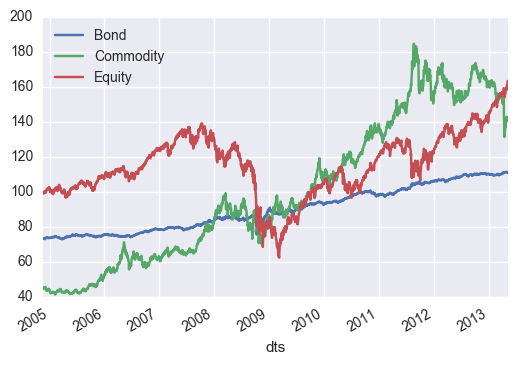

In [2]:
cols = ["dts","AGG","GLD","SPY","QQQ","IWM"]
cols = ["dts","AGG","GLD","SPY"]
num_assets = len(cols)-1
#cols = ["dts","AGG","SPY"]
df = pd.read_csv(file_etfs,usecols= cols, index_col='dts').rename(columns={"AGG":"Bond","GLD":"Commodity","SPY":"Equity"})
df.set_index(pd.to_datetime(df.index,format="%Y%m%d"),inplace=True)
df = df.dropna(0)
pt_ret = df.pct_change()
df.plot(figsize=(6,4))
np.round(pt_ret.corr(),2)


# Simple Risk Parity

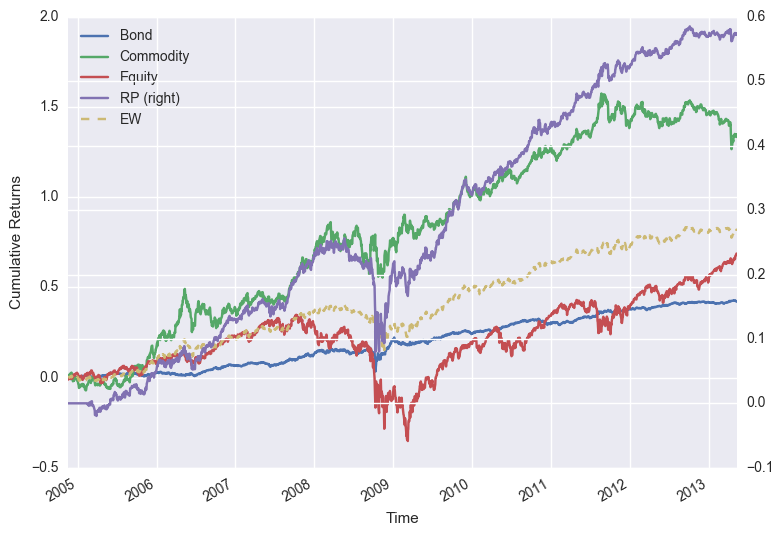

In [3]:
# Simple risk parity treats if there is no correlation among assets, thus 
# the weight is inversely proportional to recent asset volatility
# halflife used to compute asset volatility

#df_ret = pt_ret.head().unstack().reset_index().rename(columns={"level_0":"asset_id",0:"ret"})

df_std = pt_ret.rolling(window =60).std()*np.sqrt(252)
wts = (1/df_std).apply(lambda x: x/((1/df_std).sum(axis=1)))
df_ret_rp = (pt_ret * wts.shift(1)).sum(axis=1).to_frame("RP")
if num_assets == 2:
    df_ret_static = pt_ret.dot(np.array([0.4, 0.6])).to_frame("60-40")
else:
    df_ret_static = pt_ret.mean(axis=1).to_frame("EW")


ax = pt_ret.cumsum().plot()
df_ret_rp.cumsum().plot(ax =ax, secondary_y= True)
(df_ret_static).cumsum().plot(ax=ax, style=['--'])

ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
plt.tight_layout()

(-0.2, 1)

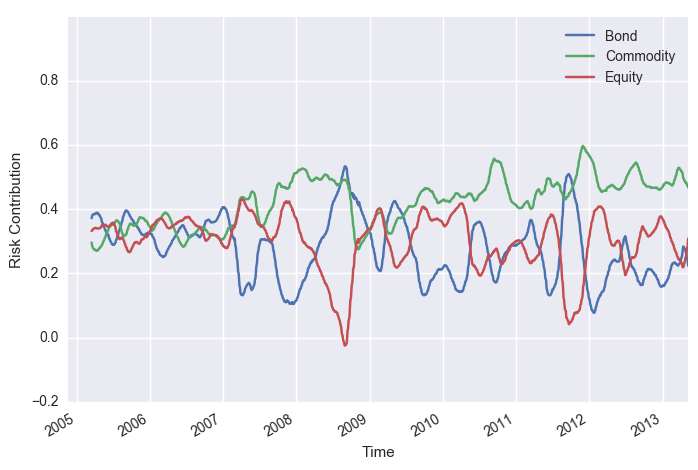

In [4]:
pt_risk_contribution = wts * 0

weighting_scheme = "60-40"



weighting_scheme = "EW"
weighting_scheme = "NRP"
lookback = 60
for i in np.arange(len(wts)):
    if i >= lookback:
        if weighting_scheme == "NRP":
            wts_vec = wts.iloc[i]
        elif weighting_scheme == "60-40":
            wts_vec = np.array([0.6,0.4])
        elif weighting_scheme == "EW":
            wts_vec = np.ones(num_assets)/num_assets
            
        Sigma = pt_ret.iloc[i-lookback+1:i,:].cov()
        var_p = wts_vec.dot(Sigma).dot(wts_vec)
        risk_contribution_vec = (wts_vec * (Sigma.dot(wts_vec)))/var_p
        pt_risk_contribution.iloc[i,:] = np.array(risk_contribution_vec)

ax = pt_risk_contribution.rolling(window=20).mean().plot()
ax.set_xlabel("Time")
ax.set_ylabel("Risk Contribution")
ax.set_ylim((-0.2,1))
#ax.set_title("Risk Contribution (Weighting Scheme: " + weighting_scheme + ")")

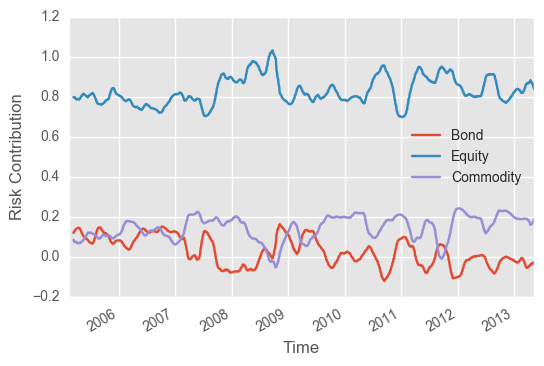

In [75]:
pt_risk_contribution["Equity"] = pt_risk_contribution[["IWM","QQQ","SPY"]].sum(axis=1)
pt_risk_contribution_asset_class = pt_risk_contribution.rename(columns={"AGG":"Bond","GLD":"Commodity"})\
    [["Bond","Equity","Commodity"]]
ax = pt_risk_contribution_asset_class.dropna().rolling(window=20).mean().plot()
ax.set_xlabel("Time")
ax.set_ylabel("Risk Contribution")

,Ann_Ret,Ann_Vol,Sharpe,MaxDD,DD_Start,DD_End,Var(95),ES(95),TR(95)
Bond,4.996839,5.499607,0.880895,-13.419330,2008-09-09,2008-10-10,6.620586,11.458563,10.658624
Commodity,15.818521,20.766981,0.657660,-30.882152,2011-08-22,2013-04-15,33.182029,49.716340,18.662359
Equity,8.099882,21.581604,0.267522,-70.003588,2007-10-09,2009-03-09,32.246978,52.991024,23.579010
EW,9.638414,10.467623,0.868442,-25.176050,2008-05-20,2008-11-20,15.612854,24.256707,10.977665
RP,6.767600,6.289351,1.044563,-17.630160,2008-05-20,2008-10-10,8.385743,13.597792,9.771122


Bond         0.684073
Commodity    0.147680
Equity       0.168247
dtype: float64

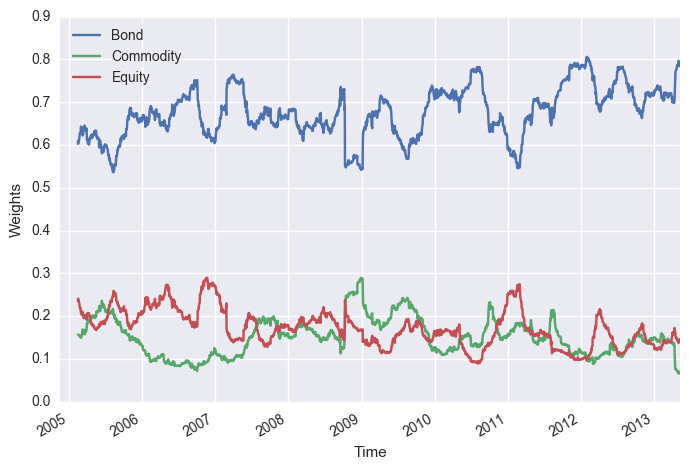

In [6]:
ax = wts.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Weights")
#On average 67% is allocated to bonds, 16% to gold and 18% to equities
wts.mean()

df_ret_all = pt_ret.join(df_ret_static).join(df_ret_rp).dropna()["2004-01":]

display(perf.get_perf_summary(df_ret_all, prds_in_yr=252))


wts["2006-01":].mean()

# Multiple Asset RP containing highly correlated assets 

,AGG,EEM,GLD,IWM,QQQ,SPY,TLT
AGG,1.00,-0.12,0.08,-0.18,-0.13,-0.10,0.54
EEM,-0.12,1.00,0.19,0.82,0.84,0.89,-0.40
GLD,0.08,0.19,1.00,0.07,0.04,0.07,0.04
IWM,-0.18,0.82,0.07,1.00,0.88,0.92,-0.44
QQQ,-0.13,0.84,0.04,0.88,1.00,0.91,-0.42
SPY,-0.10,0.89,0.07,0.92,0.91,1.00,-0.45
TLT,0.54,-0.40,0.04,-0.44,-0.42,-0.45,1.00


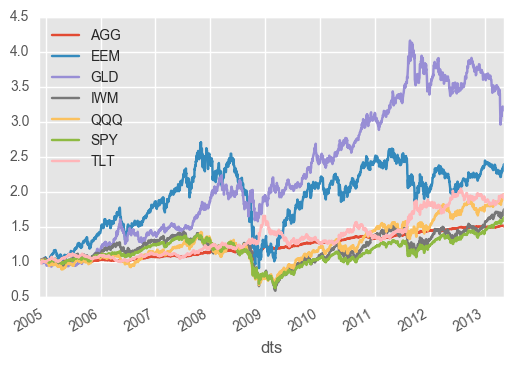

In [28]:
cols = ["dts","AGG","TLT","GLD","SPY","QQQ","IWM","EEM"]
df = pd.read_csv(file_etfs,usecols= cols, index_col='dts')
df.set_index(pd.to_datetime(df.index,format="%Y%m%d"),inplace=True)
df = df.dropna(0)
df_ret = df.pct_change()
display(np.round(df_ret.corr(),2))

ax = (1+df_ret).cumprod().plot()



# Real Risk Parity 

In [ ]:
#risk parity considering correlation
cov_df = df_ret.cov()

def wgt_wrapper(wgt, cov):
    
    a = wgt[0]**2 * cov.iloc[0, 0] + \
        wgt[0]*wgt[1] * cov.iloc[1,0] + \
        wgt[0]*(1 - wgt[0] - wgt[1]) * cov.iloc[2,0]
        
    b = wgt[0]*wgt[1] * cov.iloc[0,1] + \
        wgt[1]**2 * cov.iloc[1,1] + \
        wgt[1]*(1 - wgt[0] - wgt[1]) * cov.iloc[2,1]
        
    c = wgt[0]*(1 - wgt[0] - wgt[1]) * cov.iloc[0,2] + \
        wgt[1]*(1 - wgt[0] - wgt[1]) * cov.iloc[1,2] + \
        (1 - wgt[0] - wgt[1])**2 * cov.iloc[2,2]
        
    return abs(a - b)+ abs(b - c) + abs(a-c)

def cal_wgt(cov_df):
    ans = minimize(wgt_wrapper, [0.0, 0.0], (cov_df), bounds=((0,1), (0,1)))
    return ans.x